### 1. 仿射变换

对于二维平面来说，仿射变换就是将一个点，通过**线性变换**映射到另一个二维平面中的点。

```
平行原则：原来是平行线，仿射后也是平行线
直线原则：原来是直线，仿射以后也是直线
```

与之相对的，**非线形变换**不是仿射变换，因为其不满足仿射变换的线性性质。一个典型的非仿射变换为透视变换。

对于矩阵来说，仿射变换的结果，可以表示为矩阵的乘积。

仿射变换通常包含以下几种操作

* 平移：沿着x，y方向移动图像
* 旋转：围绕中心点旋转图像
* 缩放：缩放到指定大小
* 错切：在平面上将图像斜切一定角度

仿射变换可用于图像对齐、图像矫正、图像增强等。

#### 图像旋转

图像旋转是一种特殊的仿射变换

在pil中，图像旋转有专用的函数接口，示例如下

In [52]:
import PIL.Image as Image
import matplotlib.pyplot as plt

img = Image.open('./dataset/lena.png')
rotated_img = img.rotate(45, center=[img.width // 2, img.height // 2])

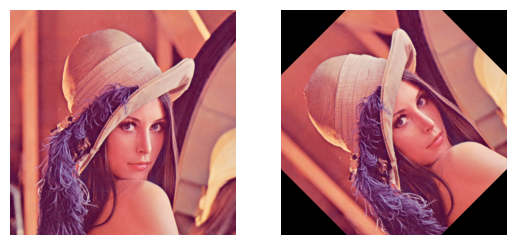

In [53]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.imshow(img)
ax2.imshow(rotated_img)

ax1.axis('off')
ax2.axis('off')

plt.show()

在pil中，使用rotate函数，分别指定旋转中心，和旋转角度，就可以实现图像的旋转。

而opencv中，提供了更加便捷灵活的函数方法。

首先，通过指定的中心和旋转角度，定义旋转矩阵；

其次，根据旋转矩阵，进行仿射变换，实现旋转。

In [54]:
import cv2

img = cv2.imread('./dataset/lena.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

M = cv2.getRotationMatrix2D([img.shape[0] // 2, img.shape[1] // 2], 45, 1)
print(M)

[[   0.70710678    0.70710678 -106.03867197]
 [  -0.70710678    0.70710678  256.        ]]


In [55]:
rotate_img = cv2.warpAffine(img, M, [512,512])

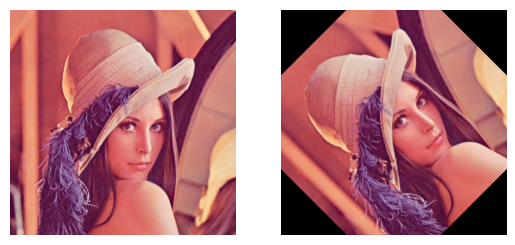

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.imshow(img)
ax2.imshow(rotate_img)

ax1.axis('off')
ax2.axis('off')

plt.show()

在opencv中，首先需要计算旋转矩阵，参数包括：
    
    - 旋转中心坐标
    - 旋转角度
    - 缩放比例/方向
    
所计算出来的矩阵M为：

$$M=\begin{bmatrix}
a_{00} & a_{01} & b_0 \\
a_{10} & a_{11} & b_1 \\
\end{bmatrix}$$


假设新坐标中的某个点$(x', y')$，对应原始图像中的某点$(x, y)$，计算公式如下：

$$x'=a_{00}x + a_{01}y + b_0$$
$$y'=a_{10}x + a_{11}y + b_1$$


而经过上述变换，即可得到变换后的坐标。

以下是一个依据旋转矩阵的底层实现，其功能与opencv提供的函数相同。

In [57]:
import numpy as np

# 首先，将图像的平面坐标扩展出一个1，可直接相乘
img_matrix = np.array([[i, j, 1] for j in range(512) for i in range(512)])
img_matrix = img_matrix.T

print(img_matrix[:10, :10])

[[0 1 2 3 4 5 6 7 8 9]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]]


In [58]:
# 其次，乘以矩阵得到新的坐标
rotated_img_matrix = np.dot(M, img_matrix)
rotated_img_matrix = np.rint(rotated_img_matrix).astype(int)
print(rotated_img_matrix[:10, :10], rotated_img_matrix.shape)

[[-106 -105 -105 -104 -103 -103 -102 -101 -100 -100]
 [ 256  255  255  254  253  252  252  251  250  250]] (2, 262144)


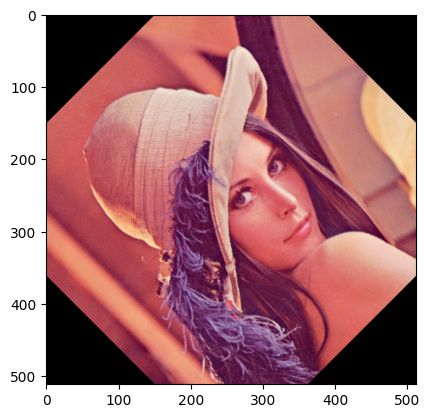

In [59]:
# 最后，按照新坐标填补像素
final_img = np.zeros_like(img)
for i in range(512):
    for j in range(512):
        num = i * 512 + j
        x = rotated_img_matrix[1, num]
        y = rotated_img_matrix[0, num]
        
        if 0 < x < 512 and 0 < y < 512:
            final_img[j, i] = img[y, x]
    

plt.imshow(final_img)
plt.show()

#### 仿射变换的一般形式

将一张图像进行仿射变换，得到新的图像。

其中需要两个步骤：

1. 计算仿射矩阵
2. 得到原图与新图的坐标对应

**如何计算仿射矩阵？**

本质上，求解仿射矩阵的过程，就是一个解方程的过程。

由于仿射矩阵中包含了6个未知数，我们需要6个方程进行求解，即3个点

方程如下所示：

$$\begin{bmatrix}
x \\
y
\end{bmatrix} = \begin{bmatrix}
a_{00} & a_{01} & b_0 \\
a_{10} & a_{11} & b_1 \\
\end{bmatrix}\times\begin{bmatrix}
x' \\
y' \\
1
\end{bmatrix}$$

带入三个点，得到

$$\begin{bmatrix}
x_1 & x_2 & x_3 \\
y_1 & y_2 & y_3
\end{bmatrix} = \begin{bmatrix}
a_{00} & a_{01} & b_0 \\
a_{10} & a_{11} & b_1 \\
\end{bmatrix}\times\begin{bmatrix}
x_1' & x_2' & x_3' \\
y_1' & y_2' & y_3' \\
1 & 1 & 1
\end{bmatrix}$$

进而，可以得到

$$\begin{bmatrix}
a_{00} & a_{01} & b_0 \\
a_{10} & a_{11} & b_1 \\
\end{bmatrix}=\begin{bmatrix}
x_1 & x_2 & x_3 \\
y_1 & y_2 & y_3
\end{bmatrix}\begin{bmatrix}
x_1' & x_2' & x_3' \\
y_1' & y_2' & y_3' \\
1 & 1 & 1
\end{bmatrix}^{-1}$$


举例来说，一个2\*2的矩形，中心点为原点。

按原点逆时针旋转45度，有：

第一组点：(1，0) --> $(\frac{\sqrt{2}}{2}, \frac{\sqrt{2}}{2})$

第二组点：(0, 1) --> $(-\frac{\sqrt{2}}{2}, \frac{\sqrt{2}}{2})$

第三组点：(-1, 0) --> $(-\frac{\sqrt{2}}{2}, -\frac{\sqrt{2}}{2})$ 

带入公式

$$\begin{bmatrix}
a_{00} & a_{01} & b_0 \\
a_{10} & a_{11} & b_1 \\
\end{bmatrix}=\begin{bmatrix}
\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2}
\end{bmatrix}\begin{bmatrix}
1 & 0 & -1 \\
0 & 1 & 0 \\
1 & 1 & 1
\end{bmatrix}^{-1}$$

### 作业

不依赖第三方库，将一个图像按照中心点，缩小为原面积的四分之一。

1. 不可使用opencv或pil库，用python底层实现
2. 提交python代码

以下是提交的py文件的基本形式（不可改动）

```
def resize(image):
    # image是读取用opencv读取完毕的numpy矩阵
    # 输出为仿射变换后的矩阵，注意要将其转化为适合图像的数据类型
    # 此处撰写代码
    return resized_image
```


#### 透视变换

区别于仿射变换，透视变换是通过变换矩阵对图像进行变形，来实现视角的转换。

在透视变换中，不仅会发生平移或者旋转，也会发生图像形变。

仿射变换需要三点求解仿射矩阵，而透视变换则需要四点标定，来获得变换矩阵

此处举例两个常见的应用：鱼眼畸变矫正和鸟瞰视角变换

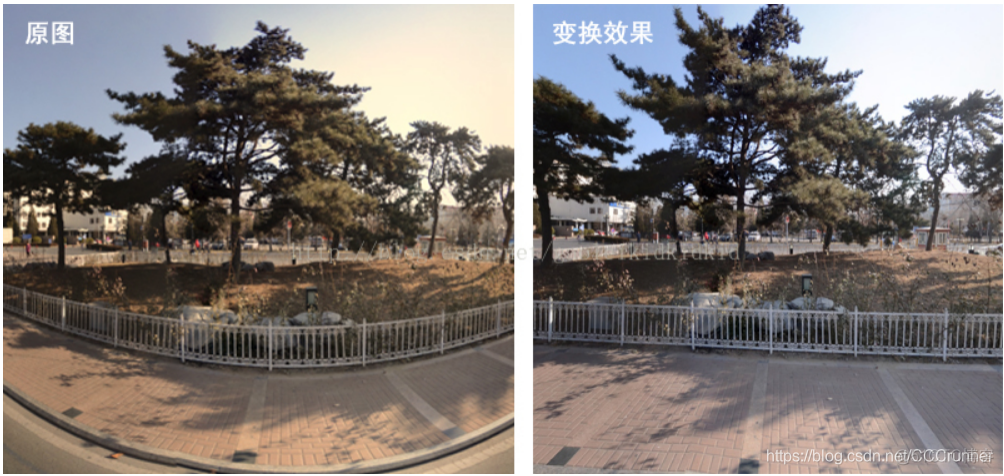

以下是一个简单的例子

In [61]:
img = cv2.imread('./dataset/lena.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

给定$(x_i, y_i)$和$(x_i', y_i')$共四对点。

透视矩阵为3\*3矩阵如下：

$$M=\begin{bmatrix}
m_{00} & m_{01} & m_{02} \\
m_{10} & m_{11} & m_{12} \\
m_{20} & m_{21} & m_{22} \\
\end{bmatrix}$$

变换的过程为：

$$\begin{bmatrix}x_i'\\y_i'\\1\end{bmatrix}=\begin{bmatrix}m_{11} & m_{12} & m_{13}\\m_{21} & m_{22} & m_{23}\\m_{31} & m_{32} & m_{33}\end{bmatrix}\begin{bmatrix}x_i\\y_i\\1\end{bmatrix}$$

$$\begin{bmatrix}x_i & y_i & 1 & 0 & 0 & 0 & -x_i'x_i & -x_i'y_i\\0 & 0 & 0 & x_i & y_i & 1 & -y_i'x_i & -y_i'y_i\end{bmatrix}\begin{bmatrix}m_{11}\\m_{12}\\m_{13}\\m_{21}\\m_{22}\\m_{23}\\m_{31}\\m_{32}\end{bmatrix}=\begin{bmatrix}x_i'\\y_i'\end{bmatrix}$$

进而，可以求得透视参数

opencv提供了便捷的计算透视矩阵的函数， 分别输入4对点的坐标，就可以实现矩阵的变换。

以将正常图像变为梯形为例，原图的点分别为(0, 0), (0, 512), (512, 0), (512, 512)

将左上右上的点保持不动，左下右下向中间靠拢一半。

得到变换后图像的四个点为：(0, 0), (0, 512), (512, 128), (512, 384)

那么透视矩阵可以由以下函数得到。

In [63]:
M = cv2.getPerspectiveTransform(np.float32([[0, 0], [0, 512], [512, 0], [512, 512]]), 
                                np.float32([[0, 0], [0, 512], [512, 128], [512, 384]]))
print(M)

[[ 2.000000e+00  0.000000e+00  0.000000e+00]
 [ 5.000000e-01  1.000000e+00  0.000000e+00]
 [ 1.953125e-03 -0.000000e+00  1.000000e+00]]


得到透视矩阵后，即可进行透视变换。

实现透视变换的方法如下


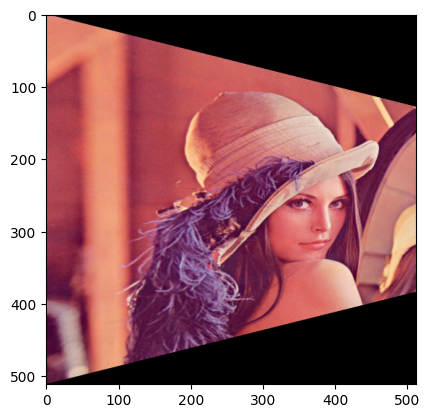

In [66]:
project_img = cv2.warpPerspective(img, M, (512, 512))
plt.imshow(project_img)
plt.show()

实际上，`warpPerspective`所实现的原理与仿射变换相同，都是先获取矩阵的坐标映射关系后，进行图像像素的对应放置。

### 作业2: 矫正以下图像

![](./dataset/grid.png)

* 任务：将上述图像变为正对镜头的视角
* 图像原图在'./dataset/grid.png'
* 提交的python文件格式如下：

```
def image_rectify(img):
    # 输入为读取好的图像numpy数据
    # 输出为矫正好的图像
    return rectified_img
```